# Train the contender on self-play episodes of the champion

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from alphazero.mcts import MCTS
from alphazero.coach import Coach
from alphazero.gomoku_game import GomokuGame as Gomoku, initial_stones
from alphazero.interfaces import TrainParams
from domoku.policies.heuristic_policy import HeuristicPolicy
from alphazero.gomoku_model import NeuralNetAdapter
from alphazero.gomoku_board import GomokuBoard
from domoku import tools as gt

In [3]:
BOARD_SIZE = 15

In [4]:
detector = HeuristicPolicy(BOARD_SIZE, cut_off=.1)
game = Gomoku(BOARD_SIZE, detector=detector, initial=initial_stones(BOARD_SIZE, 4))

2022-07-13 16:31:05.958601: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


----

In [5]:
policy = HeuristicPolicy(BOARD_SIZE, cut_off=.1)
mcts = MCTS(game, policy, cpuct=1.0, num_simulations=100, model_threshold=.4)

In [6]:
board = game.get_initial_board()  # random start positions, sometimes unfair, but so what?
print(board)
import numpy as np

# Two mood versions of the champion playing against each other = less draws
# These settings may change over the training period, once opponents get stronger.
temperatures = [0.6, 0]  # more tight vs more explorative

episode_step = 0
train_examples = []
done = policy.get_winner(board.canonical_representation())
while done is None:
    episode_step += 1
    t = temperatures[episode_step % 2]
    pi = mcts.get_action_prob(board, temperature=t)
    action = np.random.choice(len(pi), p=pi)
    board.act(action)
    print(board)
    done = policy.get_winner(board.canonical_representation())

# The player who made the last move, is the winner.
print (f"The winner is {1-board.get_current_player()}")
board.plot()

L4 D7 G5 D10 (Black next)
L4 D7 G5 D10 D8 (White next)
L4 D7 G5 D10 D8 E7 (Black next)
L4 D7 G5 D10 D8 E7 F7 (White next)
L4 D7 G5 D10 D8 E7 F7 G3 (Black next)
... D7 G5 D10 D8 E7 F7 G3 H5 (White next)
... G5 D10 D8 E7 F7 G3 H5 I4 (Black next)
... D10 D8 E7 F7 G3 H5 I4 I5 (White next)
... D8 E7 F7 G3 H5 I4 I5 F5 (Black next)
... E7 F7 G3 H5 I4 I5 F5 C8 (White next)
... F7 G3 H5 I4 I5 F5 C8 B8 (Black next)
... G3 H5 I4 I5 F5 C8 B8 C9 (White next)
... H5 I4 I5 F5 C8 B8 C9 J5 (Black next)
... I4 I5 F5 C8 B8 C9 J5 C7 (White next)
... I5 F5 C8 B8 C9 J5 C7 C10 (Black next)
... F5 C8 B8 C9 J5 C7 C10 E9 (White next)
... C8 B8 C9 J5 C7 C10 E9 F10 (Black next)
... B8 C9 J5 C7 C10 E9 F10 E10 (White next)
... C9 J5 C7 C10 E9 F10 E10 H3 (Black next)
... J5 C7 C10 E9 F10 E10 H3 K6 (White next)
... C7 C10 E9 F10 E10 H3 K6 F3 (Black next)
... C10 E9 F10 E10 H3 K6 F3 I3 (White next)
... E9 F10 E10 H3 K6 F3 I3 F4 (Black next)
... F10 E10 H3 K6 F3 I3 F4 F2 (White next)
... E10 H3 K6 F3 I3 F4 F2 G4 (Black

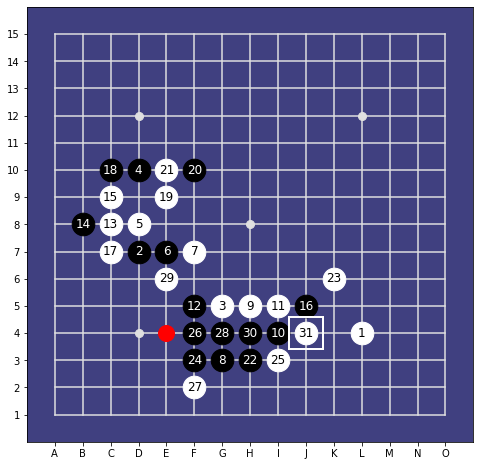

In [7]:
from copy import deepcopy
from domoku.board import GomokuBoard as LegacyBoard
board = deepcopy(board)
stones = board.stones[:-1]
stones = "".join([str(stone) for stone in stones])
board_t = LegacyBoard(n=BOARD_SIZE, disp_width=8, stones=stones, heuristics=policy)
board_t.display()

---

### For reference: The policy's opinion about that board state

In [8]:
board = GomokuBoard(BOARD_SIZE, stones)
pi, v = policy(board.canonical_representation())
print((np.array(pi)*1000).astype(int))
print(f"Value: {v}")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1   0   4   0   2   0   2   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   1   1   0   0   0   0   0   0   0]
 [  0   2   3   0   0   0   1   1   0   0   0   1   0   0   0]
 [  0   0   1   2   2   0   0   0   0   0   2   0   0   0   0]
 [  0   0   1   0 905   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   3   2   0   0   0   0   0   2   0   0   0   0]
 [  0   0   0   0   0   0   3   1   2   0   0   1   0   0   0]
 [  0   0   0   0   0   1   0   0   0   1   0   0   0   0   0]]
Value: 0.9173556091744349


---

### The search tree has a similar yet more ascertive opinion
The action counts will inform the next policy and the $max(Q_a)$ may inform the value function.

In most cases, the softmax will agree with the move actually taken, only if the chances are somewhat equally distributed, will the softmax also allow for a choice.

In [9]:
key = board.get_string_representation()
probs = mcts.compute_probs(board, temperature=1.0)
probs = np.array(probs).reshape([BOARD_SIZE, BOARD_SIZE])
print((probs*100).astype(int))
q_advice = [mcts.Q.get((key, i), -float('inf')) for i in range(225)]
print()
print(f"Value from max(Q): {np.max(q_advice)}")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 100   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]

Value from max(Q): 1.0


# Symmetries

In [10]:
math_rep = board.canonical_representation()
symmetries = game.get_symmetries(math_rep, probs)
symmetries[0][0].shape

(17, 17, 3)

We see the board diagonally flipped

In [11]:
gt.print_channels(symmetries[0][0])

shape: (17, 17, 3)
[[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 2 1 2 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 1 1 2 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 1 1 2 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 2 1 1 1 0 2 0 0 1 0 0 0 0 0 3]
 [3 0 0 0 0 0 2 1 0 2 2 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 1 2 0 1 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 2 2 2 1 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]]


In [12]:
for i in range(1):
    print((np.array(symmetries[i][1]).reshape(15, 15) * 100).astype(int))
    print()

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 100   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]



---

# Training

Would be nice to see the training converge (and overfit) with a single episode in its 8 symmetries, and validate the overfitted against a board with all stones shifted. We'd expect only minor differences due to the different border influence, but otherwise the conv-only network naturally features translation symmetry.

In [13]:
detector = HeuristicPolicy(BOARD_SIZE, cut_off=.1)
game = Gomoku(BOARD_SIZE, detector=detector, initial=initial_stones(BOARD_SIZE, 4))

/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [51]:
params = TrainParams(
    epochs_per_train=200,
    update_threshold=0.6,
    max_queue_length=8192,    # Number of game examples to keep to train the neural networks.
    num_simulations=25,
    arena_compare=2,         # Number of games to play during arena play to evaluate new network.
    cpuct=1.0,
    checkpoint_dir='./temperature/',
    load_model=False,
    load_folder_file=('/dev/models/8x100x50', 'best.pth.tar'),
    num_iters_for_train_examples_history=4,
    num_iterations=2,
    num_episodes=1,
    temperature_threshold=12
)
coach = Coach(game, params=params)

In [15]:
policy = HeuristicPolicy(BOARD_SIZE, cut_off=.1)
mcts = MCTS(game, policy, cpuct=1.0, num_simulations=100, model_threshold=.4)
examples = coach.create_trajectories(mcts, 1, shuffle=False)

   Self Play: 100%|██████████| 1/1 [01:07<00:00, 67.33s/it]


In [52]:
len(examples)

136

In [53]:
import numpy as np
ex = examples[-1]
print(len(ex), ex[0].shape, ex[2])
print((np.array(ex[1])*100).reshape((15, 15)).astype(int))

3 (17, 17, 3) 1.0
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 100   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


In [54]:
gt.print_channels(ex[0])

shape: (17, 17, 3)
[[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 1 2 1 1 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 2 1 2 2 1 0 0 0 0 0 0 3]
 [3 0 0 0 0 2 0 1 0 2 1 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 1 1 2 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]]


## Train

In [82]:
the_model = NeuralNetAdapter( BOARD_SIZE+ 2)
#the_model.policy.summary()

In [83]:
sample = np.expand_dims(examples[0][0], axis=0).astype(float)
sample.shape

(1, 17, 17, 3)

In [84]:
the_model.policy(sample, debug=True)

Potential: 23.47519302368164
Value Head: 5.130324363708496
Policy Head: 19.81228256225586


(<tf.Tensor: shape=(1, 225), dtype=float32, numpy=
 array([[0.00444712, 0.00444467, 0.00444544, 0.0044425 , 0.00444556,
         0.00444395, 0.00444463, 0.00444373, 0.00444366, 0.004444  ,
         0.00444378, 0.00444637, 0.00444581, 0.00444636, 0.00444788,
         0.00444561, 0.00444251, 0.00444467, 0.00444197, 0.00444566,
         0.0044446 , 0.00444611, 0.00444528, 0.0044467 , 0.00444449,
         0.00444376, 0.00444749, 0.00444684, 0.00444881, 0.00445003,
         0.00444673, 0.00444191, 0.00444324, 0.00444113, 0.00444454,
         0.00444563, 0.00444681, 0.0044453 , 0.00444615, 0.00444632,
         0.00444588, 0.00444554, 0.00444617, 0.00444766, 0.00445018,
         0.00444399, 0.00443934, 0.00444076, 0.0044414 , 0.00444466,
         0.00444485, 0.00444522, 0.00444482, 0.00444575, 0.00444485,
         0.00444525, 0.00444584, 0.0044467 , 0.00444592, 0.00444808,
         0.00444197, 0.00443771, 0.00444082, 0.0044394 , 0.00444051,
         0.00444145, 0.0044433 , 0.00444141, 0.00444

In [85]:
the_model.train(examples, params)

Epoch: 1, Loss: 6.7732744216918945
Epoch: 11, Loss: 6.530659198760986
Epoch: 21, Loss: 6.3686017990112305
Epoch: 31, Loss: 6.280400276184082
Epoch: 41, Loss: 6.226905345916748
Epoch: 51, Loss: 6.190488338470459
Epoch: 61, Loss: 6.162820339202881
Epoch: 71, Loss: 6.1425676345825195



KeyboardInterrupt



In [62]:
ex=examples[-8]
print(len(ex), ex[0].shape, ex[2])
print((np.array(ex[1]) * 100).reshape((15, 15)).astype(int))
gt.print_channels(ex[0])

3 (17, 17, 3) 1.0
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 100   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]
shape: (17, 17, 3)
[[3 3 3 3 3 3 3 3

In [63]:
p, v = the_model.predict(np.expand_dims(ex[0], axis=0).astype(float), debug=True)
print((p*100).numpy().reshape((15, 15)).astype(int))
print()
print(f"Value: {int(v)}")

Potential: 161500.4375
Value Head: -134.91539001464844
Policy Head: 430.17938232421875
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 99  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]

Value: -1
